In [248]:
import torch
import dlc_practical_prologue as prologue
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('libraries imported')


def display_mnist_tensor(x, title: str):
    n = int(np.sqrt(x.shape[0])) 
    plt.title(title)
    plt.imshow(x.numpy().reshape(n, n), cmap="copper") 

libraries imported


In [249]:
x = torch.randn(784)
x.view(1, -1).shape

torch.Size([1, 784])

The $\sigma$ activation function will be $tanh(x)$ while the first derivative of it is equal to $1 - tanh^2(x)$.

In [250]:
def sigma(x):
    return x.tanh()

def dsigma(x):
    return 1 - torch.pow(torch.tanh(x), 2)

y = torch.tanh(x)
new_x = torch.randn(x.shape)


A visual difference between the effect of the activation function on the input and the derivative of it.

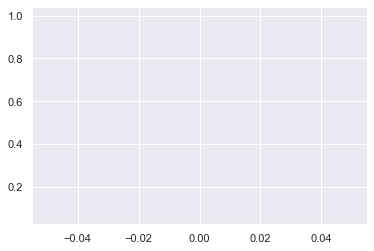

In [251]:
plt.plot(y[0], color = 'blue')
plt.plot(dsigma(y[0]), color = 'red')
plt.show()

The second step is to define the loss function (the sum of the squared distances $||v - t||_2^2$) and another function which will compute the gradient of it.

*dloss*: $\nabla f(x) = 2x$

In [252]:
def loss(v, t):
    return (v - t).pow(2).sum()

def dloss(v, t):
    return 2 * (v - t)


The forward and backward passes.

**Forward**: $x_0 \ \underrightarrow{w_1, b_1} \ s_1 \ \underrightarrow{\sigma} x_1 \ \underrightarrow{w_2, b_2} \ s_2 \ \underrightarrow{\sigma} \ x_2 $, using our parameters (weights and biases) and the previously defined $\sigma$ function.

In [253]:
def forward_pass(w1, b1, w2, b2, x):
    x0 = x # our input
    
    s1 = torch.add(torch.mv(w1, x0), b1) # summations before activation functions
    x1 = sigma(s1) # activation function
    
    s2 = torch.add(torch.mv(w2, x1), b2) # repeat
    x2 = sigma(s2)
    return x0, s1, x1, s2, x2

def backward_pass(w1, b1, w2, b2, t, x, s1, x1, s2, x2, dl_dw1, dl_db1, dl_dw2, dl_db2):
    x0 = x
    dl_dx2 = dloss(x2, t) # gradient of the loss function with respect to our target t
    dl_ds2 = dsigma(s2) * dl_dx2
    dl_dx1 = w2.t().mv(dl_ds2)
    dl_ds1 = dsigma(s1) * dl_dx1

    # The summation of each of the partial derivatives
    dl_dw2.add_(dl_ds2.view(-1, 1).mm(x1.view(1, -1)))
    dl_db2.add_(dl_ds2)
    dl_dw1.add_(dl_ds1.view(-1, 1).mm(x0.view(1, -1)))
    dl_db1.add_(dl_ds1)

We start by loading the MNIST training and testing data sets which we will use to train this network. The sets are automatically normalized and the targets are set as *one hot labels* vectors.

Then the following parameters for the training network are set: *learning rate (step size)* **$\eta$**, *number of hidden layers*, *standard deviation* **$\epsilon$** of the normal distribution where the weights are drawn from.

In [254]:
train_input, train_target, test_input, test_target = prologue.load_data(one_hot_labels=True, normalize=True)

print('train_input', train_input.size(), 'train_target', train_target.size())
print('test_input', test_input.size(), 'test_target', test_target.size())

n = train_input.size(0)  ## total train samples
eta = 1e-1 / n           ## learning rate (step size of gradient descent)
zeta = 0.9
epsilon = 0.000001

n_hidden_layers = 50     ## number of layers
n_classes = train_target.size(1)

train_target = train_target * zeta
test_target = test_target * zeta

eta

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
train_input torch.Size([1000, 784]) train_target torch.Size([1000, 10])
test_input torch.Size([1000, 784]) test_target torch.Size([1000, 10])


0.0001

An input of $(28 \times 28) = 784$ gets multiplied witht the first weight vector $w1$ ($50 \times 784$) of our decided 50 hidden layers then the bias $b1 (50 \times 1)$ is added to get the value $x1 (50 \times 1) = \sigma(s1)$. Then at the second layer the previously computed input $x1$ gets multiplied with the second weight vector $w2$ $(10 \times 50)$ in order to create the final output $x2$ $(10 \times 1)$ $= \sigma(s2)$ that has the same rows as number of *MNIST* classes.

In [255]:
w1 = torch.empty(n_hidden_layers, train_input.size(1)).normal_(0, epsilon) ## 50, 784
b1 = torch.empty(n_hidden_layers).normal_(0, epsilon) ## 50
w2 = torch.empty(n_classes, n_hidden_layers).normal_(0, epsilon) ## 10, 50
b2 = torch.empty(n_classes).normal_(0, epsilon) ## 10


dl_dw1 = torch.empty(w1.size())
dl_db1 = torch.empty(b1.size())
dl_dw2 = torch.empty(w2.size())
dl_db2 = torch.empty(b2.size())

print('Shapes - Input x: {}, Weights w1: {}, Bias b1: {}, Weights w2: {}, Bias b2: {}'.format(train_input[0].shape, w1.shape, b1.shape, w2.shape, b2.shape))

Shapes - Input x: torch.Size([784]), Weights w1: torch.Size([50, 784]), Bias b1: torch.Size([50]), Weights w2: torch.Size([10, 50]), Bias b2: torch.Size([10])


Setting up the network and computing the test error for each iteration.

In [256]:
n_iterations = 1000

# Back-prop
acc_loss = 0
nb_train_errors = 0

dl_dw1.zero_()
dl_db1.zero_()
dl_dw2.zero_()
dl_db2.zero_()

for i in range(n_iterations):
    acc_loss = 0
    nb_train_errors = 0

    for j in range(n):
        x0, s1, x1, s2, x2 = forward_pass(w1, b1, w2, b2, train_input[j])

        pred = x2.max(0)[1].item()
        if train_target[j, pred] < 0.5: nb_train_errors = nb_train_errors + 1
        acc_loss = acc_loss + loss(x2, train_target[j])

        ## the back prop to compute the partial derivatives in order to update the weights
        backward_pass(w1, b1, w2, b2,
                      train_target[j],
                      x0, s1, x1, s2, x2,
                      dl_dw1, dl_db1, dl_dw2, dl_db2)

    # Gradient Step to update the weights
    w1 = w1 - eta * dl_dw1
    b1 = b1 - eta * dl_db1
    w2 = w2 - eta * dl_dw2
    b2 = b2 - eta * dl_db2

    # Test error
    nb_test_errors = 0

    for j in range(test_input.size(0)):
        _, _, _, _, x2 = forward_pass(w1, b1, w2, b2, test_input[j])

        pred = x2.max(0)[1].item()
        if test_target[j, pred] < 0.5: nb_test_errors = nb_test_errors + 1

    print('Iteration {:d}, acc_train_loss: {:.02f}, acc_train_error: {:.02f}%, test_error: {:.02f}%'
          .format(i + 1,
                  acc_loss,
                  (100 * nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))

Iteration 1, acc_train_loss: 810.00, acc_train_error: 89.50%, test_error: 90.10%
Iteration 2, acc_train_loss: 780.58, acc_train_error: 88.30%, test_error: 90.10%
Iteration 3, acc_train_loss: 744.13, acc_train_error: 88.30%, test_error: 90.10%
Iteration 4, acc_train_loss: 728.27, acc_train_error: 88.30%, test_error: 90.10%
Iteration 5, acc_train_loss: 744.53, acc_train_error: 88.30%, test_error: 90.10%
Iteration 6, acc_train_loss: 780.21, acc_train_error: 88.30%, test_error: 90.10%
Iteration 7, acc_train_loss: 809.20, acc_train_error: 88.30%, test_error: 90.10%
Iteration 8, acc_train_loss: 811.07, acc_train_error: 88.30%, test_error: 90.10%
Iteration 9, acc_train_loss: 784.53, acc_train_error: 88.30%, test_error: 90.10%
Iteration 10, acc_train_loss: 748.22, acc_train_error: 88.30%, test_error: 90.10%
Iteration 11, acc_train_loss: 728.58, acc_train_error: 88.30%, test_error: 90.10%
Iteration 12, acc_train_loss: 740.72, acc_train_error: 88.30%, test_error: 90.10%
Iteration 13, acc_train_l